In [1]:
import os
import sys
if not os.getcwd().endswith("Submodular"):
    sys.path.append('../Submodular')    

In [2]:
import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric
from  torch_geometric.utils import remove_self_loops, add_remaining_self_loops, add_self_loops
from ipynb.fs.full.Dataset import get_data
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
import numpy as np
from scipy import linalg
from sklearn.neighbors import NearestNeighbors
import os
import pickle
import torch.nn as nn
import copy
import random
from collections import defaultdict

In [4]:
import torch
from torch_geometric.data import Data
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.utils.convert import to_networkx, from_networkx
import time
from torch_geometric.utils import coalesce, degree

In [5]:
x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
edge_index = edge_index-1
data = Data(x=x, y=y, edge_index = edge_index)

In [6]:
def get_pos(edge_index = None, y = None, n = None):
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    edges = edge_index.t().tolist()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    
    return pos

def draw_graph(edge_index = None, y = None, n = None, pos = None, G = None):
    # Create a random graph
    #edge_index = data.edge_index
    plt.figure(figsize=(5, 5))
    
    if G is None:
        # Convert the edge index to a NetworkX graph
        G = nx.Graph()
        nodes = range(n)
        G.add_nodes_from(nodes)
        edges = edge_index.t().tolist()
        G.add_edges_from(edges)

    # Plot the graph
    if pos is None:
        pos = nx.spring_layout(G)
        #pos = nx.random_layout(G)
        #pos = nx.spectral_layout(G)
    nx.draw(G, pos, with_labels=True, node_color=y.tolist(), cmap=plt.cm.get_cmap('cool', max(y)+1))
    plt.show()
    
    return G

# G = draw_graph(data.edge_index, data.y, data.num_nodes)

In [7]:
class EdgeLoader(torch.utils.data.DataLoader):

    def __init__(self, data, batch_size: int, metric='cosine', log: bool = True, **kwargs):

        assert not data.edge_index.is_cuda
        self.data = data
        self.__batch_size__ = batch_size
        self.log = log
        self.E = data.num_edges
        self.metric = metric
        super().__init__(self, batch_size=batch_size, **kwargs)
    
    def __len__(self):
        return self.E

    def __getitem__(self, idx):
        edge_idx = self.data.edge_index[:,idx]
        x = self.data.x[edge_idx[0]].unsqueeze(0)
        y = self.data.x[edge_idx[1]].unsqueeze(0)
        
        if self.metric=='euclidean':            
            return nn.PairwiseDistance(p=2)(x, y)
        
        return F.cosine_similarity(x, y, dim=-1)

    
def compute_edge_weight(data, metric='cosine', log=True):

    num_workers = 8  if data.num_edges>1000000 else 0
    loader = EdgeLoader(data, batch_size=1024*256, metric = metric, log=log, num_workers=num_workers, shuffle=False, drop_last=False)

    edge_weight=[]

    if log:
        pbar = tqdm(total=data.num_edges)
        pbar.set_description(f'Edges')

    for i, batch in enumerate(loader):
        edge_weight.append(batch.view(-1))        
        if log:pbar.update(batch.shape[0])

    if log:pbar.close()
    
    edge_weight = torch.cat(edge_weight)
    
    return edge_weight

In [8]:
# data.e_weight = compute_edge_weight(data, metric = 'euclidean')
# print(data.e_weight)
# data
# pos = get_pos(data.edge_index, data.y, data.num_nodes)
# draw_graph(data.edge_index, data.y, data.num_nodes, pos=pos)

In [9]:
def print_graph(G):
    print(G)

    for node, data in G.nodes(data=True):
        print(f"Node {node} attributes: {data}")

    for src, tgt, attr in G.edges(data=True):
        print(f"Edge ({src}, {tgt}) attributes: {attr}")

    return None

In [10]:
def SpanningTree(G, params):
    if params['mst']['minimum'] == True:
        mst_G = nx.minimum_spanning_tree(G)            
    elif params['mst']['minimum'] == False:
        mst_G = nx.maximum_spanning_tree(G)
    else:
        try:
            mst_G = nx.random_spanning_tree(G, weight='e_weight', multiplicative=True)
        except:
            print('No connected spanning tree')
            return None
    return mst_G

In [11]:
def KNNgraph(G, params, log=False):
    
    k_subgraph = nx.Graph()
    
    if log:
        pbar = tqdm(total=data.num_nodes)
        pbar.set_description(f'Nodes')
    
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        
        neighbors.sort(key=lambda x: G[node][x]['e_weight'], reverse = not params['knn']['minimum'])

        for i in range(min(params['knn']['k'], len(neighbors))):
            k_subgraph.add_edge(node, neighbors[i], **G[node][neighbors[i]])
            
        if log:
            pbar.update(1)
            
    if log:
        pbar.close()
            
    return k_subgraph

In [12]:
def bMatch(G, params, log=False):
    b_matching = set()
    degree = {node: 0 for node in G.nodes()}
    
    if log:
        pbar = tqdm(total=data.num_edges)
        pbar.set_description(f'Edges')
    
#     edges = G.edges()
#     if params['bmatch']['weighted']:
#         edges = sorted(G.edges(data=True), key=lambda x: x[2]['e_weight'])
        
    # Iterate over edges and build the b-matching
    
    for u, v in G.edges():
        if degree[u] < params['bmatch']['b'] and degree[v] < params['bmatch']['b']:
            b_matching.add((u, v))
            degree[u] += 1
            degree[v] += 1
            
        if log:
            pbar.update(1)
            
    if log:
        pbar.close()

    b_matching_subgraph = nx.Graph()
    b_matching_subgraph.add_nodes_from(G.nodes())
    b_matching_subgraph.add_edges_from(b_matching)

    return b_matching_subgraph

In [13]:
# def TSpanner(G, params):
    
#     #tspanner_graph  = nx.spanner(G, stretch=params['spanner']['t'], weight=params['spanner']['weight'],seed=1)
#     #tspanner_graph  = nx.spanner(G, stretch=params['spanner']['t'], weight=None,seed=1)
#     tspanner_graph  = nx.spanner(G, stretch=max(params['spanner']['t'], np.ceil(np.log(G.number_of_nodes()))), weight=None,seed=1)
    
#     return tspanner_graph

In [14]:
import ipynb.fs.full.Spanner as NxSpanner

In [16]:
def TSpanner(G, params):
    
    k = max(params['spanner']['t'], np.ceil(np.log(G.number_of_nodes()))) 
    
    if params['spanner']['method']=='vegas':
        return nx.spanner(G, stretch=k, weight=None,seed=1)
            
    elif params['spanner']['method']=='baswana':
         
        return nx.sparsifiers.spanner(G, 2*k-1, weight=None)
    
    elif params['spanner']['method']=='halparin':
        return NxSpanner.halperin_zwick_spanner(G, k)
    
    else: ##greedy by default
        return NxSpanner.greedy_spanner(G, k)

In [17]:
def RandomNeighbor(G, params, log=False):
    k_subgraph = nx.Graph()
    
    if log:
        pbar = tqdm(total=data.num_nodes)
        pbar.set_description(f'Nodes')
    
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        
#         print("node",node,"->",neighbors)
        
        random.shuffle(neighbors)
        
        for i in range(min(params['random']['k'], len(neighbors))):
            k_subgraph.add_edge(node, neighbors[i], **G[node][neighbors[i]])
#             print("added", node,neighbors[i])

        if log:
            pbar.update(1)
    if log:
        pbar.close()
            
    return k_subgraph

In [18]:
method_name = "spanner"

params = {
    'mst':{'minimum':False},
    'knn':{'k':25,'minimum':False},
    'bmatch':{'b':25, 'weighted':True},
    'spanner':{'t':5,'weight':None, 'method':'greedy'},
    'random':{'k':25},
    'spectral':{'epsilon':0.1}
}

Data directory:  /scratch/gilbreth/das90/Dataset/
Result directory: /scratch/gilbreth/das90/Dataset/RESULTS/

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


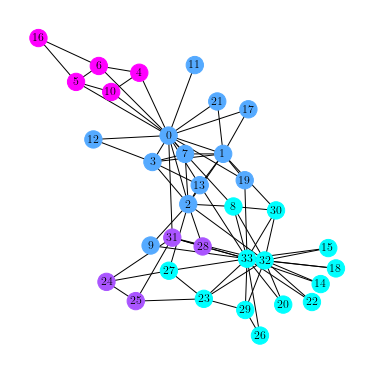

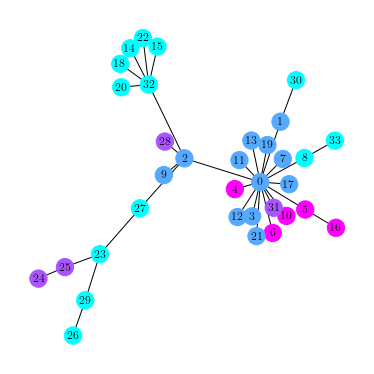

In [19]:
data, dataset = get_data('karate')
G = draw_graph(data.edge_index, data.y, data.num_nodes)
mst_G = TSpanner(G, params)
draw_graph(data.edge_index, data.y, data.num_nodes, G=mst_G)

In [20]:
def get_degree(G):
    average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
    return average_degree

In [21]:
def sparse_graph(data, K=2, method_name='mst', params=params, draw=False, log=True):
    
    if draw: 
        if 'pos' not in locals(): pos = get_pos(data.edge_index, data.y, data.num_nodes)
    
    G = to_networkx(data, edge_attrs=['e_weight'], node_attrs=['x'], to_undirected=True)
    graph_collections=[]
    graph_weights = []
    graph_degrees = []
    
    prev_deg = get_degree(G) 
    
    if log:
        print(f'Starting d: {prev_deg:0.2f}')
        
    
    for i in range(K):    
        
        if log: print(method_name,": ",i, end=' ... ')

        mst_G = None
        
        if method_name == 'mst':        
            mst_G = SpanningTree(G, params)
        elif method_name == 'knn':
            mst_G = KNNgraph(G, params, log)
        elif method_name == 'bmatch':
            mst_G = bMatch(G, params, log)            
        elif method_name == 'spanner':
            mst_G = TSpanner(G, params)
        elif method_name == 'random':
            mst_G = RandomNeighbor(G, params, log)            
        else:
            raise Exception("Select from ['mst','knn','bmatch','spectral','spanner','random']")
        
        if mst_G == None:
            break
        
        nodes_G = set(G.nodes())
        nodes_mst_G = set(mst_G.nodes())

        for node in nodes_G.difference(nodes_mst_G):
            mst_G.add_node(node)
        
        graph_collections.append(mst_G)
        graph_weights.append(mst_G.size(weight='e_weight'))        
        
        prev_deg = get_degree(mst_G)
        graph_degrees.append(prev_deg)
        
        if log: print(f'DONE: {i} d = {prev_deg:0.2f}')
            
        dG = nx.difference(G, mst_G)   
        for u, v in dG.edges():dG[u][v]['e_weight'] = G[u][v]['e_weight']
        G = dG
        
        deg = get_degree(G)
        if log: print(f'Remainder d = {deg:0.2f}')
        
        if i==K-1 or deg<prev_deg:   
            if log: print("Leftover: ... DONE: ",K)
            graph_collections.append(G)
            graph_weights.append(G.size(weight='e_weight'))                    
            graph_degrees.append(deg)
            break
            
    
    if draw:
        for i,g in enumerate(graph_collections):
            
            if i == len(graph_collections)-1:
                print(method_name,": leftover",)
            else:
                print(method_name,": ",i)
            
            draw_graph(data.edge_index, data.y, data.num_nodes, pos=pos, G=g)
    
    return graph_collections, graph_weights, graph_degrees


In [22]:
# sparse_graph(data, K=2, method_name = method_name, params=params, draw=True, log=True)

In [23]:
def custom_from_networkx(G):
    t = time.time()    
    G = nx.convert_node_labels_to_integers(G)
#     print("nx.convert_node_labels_to_integers(G)", time.time()-t); t = time.time()
    
#     G = G.to_directed()
#     print("G = G.to_directed()", time.time()-t); t = time.time()
    
    edges = list(G.edges)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    #print("torch.tensor(edges, dtype=torch.long).t().contiguous()", time.time()-t); t = time.time()

    data = defaultdict(list)
    data['edge_index'] = edge_index.view(2, -1)
    data = torch_geometric.data.Data.from_dict(data)
    #print("data = torch_geometric.data.Data.from_dict(data)", time.time()-t); t = time.time()
    data.num_nodes = G.number_of_nodes()

    return data

In [24]:
def cg_weights(K):        
    if K==1: return [1]
    fsc = int(np.ceil(K * 0.3333))
    ssc = int(np.ceil(K * 0.3333))
    tsc = K - fsc - ssc

    fsw = 0.50 / fsc
    ssw = 0.30 / ssc
    
    if tsc>0:
        tsw = 0.20 / tsc
        return ([fsw] * fsc + [ssw] * ssc + [tsw] * tsc)
    else:
        return ([fsw] * fsc + [ssw] * ssc)

# cg_weights(1)

In [25]:
def get_random_sparse(data, sel_K = 2, max_K = 5, metric = 'cosine', minimum=False, draw=False, log=True, dataset_name='default', recompute=True, method_name='mst',params=params):
    #### function part 1 ----------------------
    
    if log:start =  time.time()
    
    graph_filename = dataset_name+"_graphs"+method_name+str(max_K)+metric+str(minimum)+".pkl"
    weight_filename = dataset_name+"_weights_"+method_name+str(max_K)+metric+str(minimum)+".pkl"
    degree_filename = dataset_name+"_degrees_"+method_name+str(max_K)+metric+str(minimum)+".pkl"
    edge_weight_filename = dataset_name+"_edge_weight"+metric+".pkl"
    
    if (os.path.exists(graph_filename)==False
        or os.path.exists(weight_filename)==False
        or os.path.exists(degree_filename)==False
    or recompute==True):    
        
        if log:print('Computing: ',graph_filename)        
        
        if os.path.exists(edge_weight_filename) == False or recompute== True:        
            data.e_weight = compute_edge_weight(data, metric = metric, log=log)
            file_handle_graph = open(edge_weight_filename, 'wb')
            pickle.dump(data.e_weight, file_handle_graph)
            file_handle_graph.close()
        else:
            if log:
                print('Loading edge_weight: ',edge_weight_filename)
            file_handle_graph = open(edge_weight_filename, 'rb')
            data.e_weight = pickle.load(file_handle_graph)
            file_handle_graph.close()                
            
            
        
        graph_collections, graph_weights, graph_degrees = sparse_graph(data, K=max_K, draw=draw, log=log, method_name=method_name, params=params)        
        graph_weights = [max((len(graph_weights)-i)*1e-1,w) for i,w in enumerate(graph_weights)]
                
        #remove attirbutes from graphs
        
        t = time.time()
        ###remove all attributes for compose
        for G in graph_collections:
        
            for node in G.nodes:
                G.nodes[node].clear()

            # Drop all edge attributes
            for edge in G.edges:
                G.edges[edge].clear()
        ####
        if log: print("Collections attirbutes removal time:",time.time()-t)
        
        #-------------------
        
        file_handle_graph = open(graph_filename, 'wb')
        pickle.dump(graph_collections, file_handle_graph)
        file_handle_graph.close()
        
        file_handle_weight = open(weight_filename, 'wb')
        pickle.dump(graph_weights, file_handle_weight)
        file_handle_weight.close()
        
        file_handle_weight = open(degree_filename, 'wb')
        pickle.dump(graph_degrees, file_handle_weight)
        file_handle_weight.close()
        
    else:        
        if log: print('Loading..')
        
        file_handle_graph = open(graph_filename, 'rb')
        graph_collections = pickle.load(file_handle_graph)
        file_handle_graph.close()
        
        file_handle_weight = open(weight_filename, 'rb')
        graph_weights = pickle.load(file_handle_weight)
        file_handle_weight.close()
        
        file_handle_weight = open(degree_filename, 'rb')
        graph_degrees = pickle.load(file_handle_weight)
        file_handle_weight.close()
    
    
    
    if log:        
        print("Subgraph weights: ", graph_weights)
        print("Subgraph degress: ", graph_degrees)

        end = time.time()
        print("Graph loading or computation time: ", end-start)
    
        
    
    #### function part 2 ----------------------
    
    if log:start =  time.time()
    
#     #graph_collections, graph_weights = sparse_graph(data, K=max_K, minimum=minimum, draw=draw, log=log)    
#     if minimum == False:
#         sel_mst_index = np.random.choice(len(graph_weights), size=min(sel_K,len(graph_weights)), replace=False, p=graph_weights/np.sum(graph_weights))
#     else:
#         graph_weights = [(len(graph_weights)-i)*1e-3 for i,w in enumerate(graph_weights)]
#         sel_mst_index = np.random.choice(len(graph_weights), size=min(sel_K,len(graph_weights)), replace=False, p=graph_weights/np.sum(graph_weights))    
    
    if graph_degrees[-1]>2*graph_degrees[0]:
        graph_weights = cg_weights(len(graph_collections)-1)    
    else:
        graph_weights = cg_weights(len(graph_collections))    
    sel_mst_index = np.random.choice(len(graph_weights), size=min(sel_K,len(graph_weights)), replace=False, p=graph_weights/np.sum(graph_weights))    
    
    if log: 
        print(method_name," weights: ", graph_weights)
        print("Selected",method_name,": ", sel_mst_index, " Weights: ",[graph_weights[i] for i in sel_mst_index])
    
    
    col_G = None
    if len(sel_mst_index)==1:
        col_G = graph_collections[sel_mst_index[0]]
        #data_updated = from_networkx(graph_collections[sel_mst_index[0]], group_edge_attrs=['e_weight'])        
        
        t1 = time.time()        
        data_updated = custom_from_networkx(graph_collections[sel_mst_index[0]]) 
        print("from networkx time:", time.time()-t1)
        
    else:
        t1 = time.time()        
                
        col_G = nx.compose_all([graph_collections[i] for i in sel_mst_index])
        if log:print("compose all time:", time.time()-t1)
        
        
#         t1 = time.time()        
#         # Drop all node attributes
#         for node in col_G.nodes:
#             col_G.nodes[node].clear()

#         # Drop all edge attributes
#         for edge in col_G.edges:
#             col_G.edges[edge].clear()
            
#         if log:print("Attribute removal time:", time.time()-t1)
        
#         print(col_G.nodes(data=True))
#         print(col_G.edges(data=True))
        
        t1 = time.time()        
        #data_updated = from_networkx(col_G, group_edge_attrs=['e_weight'])        
        #data_updated = from_networkx(col_G, group_edge_attrs=None,group_node_attrs=None)
        data_updated = custom_from_networkx(col_G)
                
        if log:print("from networkx time:", time.time()-t1)

    if draw:
        print("Composite:")
        if 'pos' not in locals(): pos = get_pos(data.edge_index, data.y, data.num_nodes)
        draw_graph(data.edge_index, data.y, data.num_nodes, pos=pos, G=col_G)

#     data_updated.edge_attr = data_updated.edge_attr.view(-1)     
    #data_updated.edge_attr = None
    #edge_index, edge_attr = add_remaining_self_loops(edge_index = data_updated.edge_index, edge_attr = data_updated.edge_attr, num_nodes = data.num_nodes)
    
    if log:
        end = time.time()
        print("Graph compose time: ", end-start)
    
    #print(edge_index, edge_attr)    
    
#     data_updated.e_weight = edge_attr 
#     data_updated.edge_index = edge_index
    
    return data_updated, sel_mst_index

In [26]:
# data_updated, sel_mst_index = get_random_sparse(copy.copy(data), sel_K = 3, max_K = 2, metric = 'cosine', 
#                                                 minimum='rand', draw=True, log=True, dataset_name='default',
#                                                 recompute=True, method_name=method_name, params=params)
# data_updated

In [27]:
def precompute():
    ALL_DATASETS = [
        "Cornell",
        "Texas",
        "Wisconsin",
        "reed98",
        "amherst41",
        "penn94",
        "Roman-empire",
        "cornell5",
        "Squirrel",
        "johnshopkins55",
    #     "AmazonProducts", #error
        "Actor",
        "Minesweeper",
        "Questions",
        "Chameleon",
        "Tolokers",
    #     "Flickr", #error
    #     "Yelp", #error
        "Amazon-ratings",
        "genius",
        "cora",
        "CiteSeer",
        "dblp",
        "Computers",
        "pubmed",
        "Reddit",
        "cora_ml",
        "Cora",
    #     "Reddit2", #error
        "CS",
        "Photo",
        "Physics",
        "citeseer",    
        'pokec',
       'arxiv-year',
    #     'snap-patents', #error
    #     'twitch-gamer', #error
    #     'wiki', #error
    ]
    
    
    ALL_DATASETS = ['karate']
    
    for dataset_name in ALL_DATASETS:
    
    
        print(dataset_name)
        data, dataset = get_data(dataset_name, log=False)  
        
        print(data)

        data_updated, sel_mst_index = get_random_sparse(copy.deepcopy(data), sel_K = 2, max_K = 5, metric = 'cosine', 
                                                        minimum=False, draw=False, log=True, 
                                                        dataset_name=DIR+dataset_name, recompute=False,
                                                        method_name=method_name,params=params)

        print(data_updated, sel_mst_index)
    
    return data_updated


In [28]:
# #all_methods = ['mst','knn','bmatch','spanner','random']
all_methods = ['spanner']

for method_name in all_methods:
    precompute()

karate
Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], val_mask=[34], test_mask=[34])
Loading..
Subgraph weights:  [33.0, 30.0, 0.1]
Subgraph degress:  [1.9411764705882353, 1.7647058823529411, 0.8823529411764706]
Graph loading or computation time:  0.00579833984375
spanner  weights:  [0.5, 0.3, 0.2]
Selected spanner :  [1 0]  Weights:  [0.3, 0.5]
compose all time: 0.00026106834411621094
from networkx time: 0.011525869369506836
Graph compose time:  0.015379190444946289
Data(edge_index=[2, 63], num_nodes=34) [1 0]


In [29]:
# if __name__ == '__main__':    
    
#     all_methods = ['mst','knn','bmatch','spanner','random']
#     #all_methods = ['mst']

#     # for i in range(10):
#     for method_name in all_methods:
#         precompute()
    
#     None